# Los Angeles Real Estate Price Prediction

## Part 2: Explore Spatial Relationships

Real estate prices are something that are tied not only to the attributes of the property, such as the lot size, house size, and other variables, but also the conditions around them that exist in space. 
This could be demographics, nearby sales, neighborhoods, proximity to business districts, etc.

To truly understand and predict prices we need to look at the spatial variables that make up the conditions around a property. In this notebook we will explore that further using real estate sales data from 2017 to 2019 in Los Angeles County.

This data has been imported into CARTO, a spatial data science platform and PostGIS database, and will be brought into the notebook using CARTOFrames, a library that will allow us to interface with data in our CARTO account and create map visualizations. 

The data consists of two datasets, the first being historical sales data from the Los Angeles County Office of the Assessor:    

- [Property Assessment Information System Map](http://maps.assessor.lacounty.gov/GVH_2_2/Index.html?configBase=http://maps.assessor.lacounty.gov/Geocortex/Essentials/REST/sites/PAIS/viewers/PAIS_hv/virtualdirectory/Resources/Config/Default)
- [Sales Parcels](http://assessor.gis.lacounty.gov/assessor/rest/services/PAIS/pais_sales_parcels/MapServer/0)
- [All Parcels](http://assessor.gis.lacounty.gov/assessor/rest/services/PAIS/pais_parcels/MapServer/0)

And parcel information from the LA County Open Data Portal:

- [2018 Property Parcels](https://data.lacounty.gov/Parcel-/Assessor-Parcels-Data-2018/mk7y-hq5p)

Our goals for this project are:


1. To import and clean the real estate data 
2. Exploratory (spatial) data analysis
3. Limit our analysis to one category of property and explore relevant features
4. Feature engineering and tests with various machine learning models
5. Add spatial features to the data and explore spatial relationships
6. Test the model with spatial features to see the impact
7. Evaluate our model and deploy it for production usage


In [3]:
import pandas as pd
import cartoframes
import seaborn as sns
import numpy as np
import libpysal
from cartoframes import Credentials
from cartoframes.contrib import vector

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.pylabtools import figsize

pd.set_option('display.max_columns', 500)
sns.set_style("white")
sns.set_style("ticks")
sns.despine()


USERNAME = 'mforrest-isolines'  
APIKEY = '07ab3fb439d92c5f06cfec08bb3417d209c646d8'
creds = Credentials(username=USERNAME, key=APIKEY)

cc = cartoframes.CartoContext(creds=creds)

<Figure size 432x288 with 0 Axes>

In [4]:
sfr = cc.read('la_singlefamilyhomes')

In [5]:
sfr.head(2)

,ain,bathrooms,bedrooms,effectiveyearbuilt,formatted_saledate,formatted_saleprice,formatted_size,generalusetype,impbaseyear,improvementvalue,landbaseyear,landvalue,mult_geom,plot_id,propertylocation,propertytype,propertyusecode,recordingdate,rollyear,saaddr,saaddr2,safract,saledate,saleprice,saleyear,sanum,sastr,saunit,size,specificusedetail1,specificusedetail2,specificusetype,sqftmain,taxratearea,taxratearea_city,the_geom,totbuildingdatalines,units,yearbuilt,zipcode_p
cartodb_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
112031,5504028122,1,2,1992,05/21/2018,"$548,005",979,Residential,2009,201905,2009,188550,1,81377,"620 S GRAMERCY PL, 319 LOS ANGELES CA 90005",CND,010E,20090619,2018,"620 S GRAMERCY PL, 319",LOS ANGELES CA 90005,,2018,548005,2018,620,GRAMERCY PL,319,979,,Condo Conversion,Single Family Residence,979,6657,LOS ANGELES,0106000020E61000000100000001030000000100000018...,1,1,1990,90005-3271
121718,8464030012,2,3,1956,04/04/2018,"$470,004","1,109",Residential,1975,27124,1975,18072,1,133764,1004 BROMLEY AVE LA PUENTE CA 91746,SFR,0100,20040628,2018,1004 BROMLEY AVE,LA PUENTE CA 91746,,2018,470004,2018,1004,BROMLEY AVE,,1109,,,Single Family Residence,1109,2224,unincorporated,0106000020E6100000010000000103000000010000000F...,1,1,1956,91746-1609


In [6]:
sfr.columns.values

array(['ain', 'bathrooms', 'bedrooms', 'effectiveyearbuilt',
       'formatted_saledate', 'formatted_saleprice', 'formatted_size',
       'generalusetype', 'impbaseyear', 'improvementvalue',
       'landbaseyear', 'landvalue', 'mult_geom', 'plot_id',
       'propertylocation', 'propertytype', 'propertyusecode',
       'recordingdate', 'rollyear', 'saaddr', 'saaddr2', 'safract',
       'saledate', 'saleprice', 'saleyear', 'sanum', 'sastr', 'saunit',
       'size', 'specificusedetail1', 'specificusedetail2',
       'specificusetype', 'sqftmain', 'taxratearea', 'taxratearea_city',
       'the_geom', 'totbuildingdatalines', 'units', 'yearbuilt',
       'zipcode_p'], dtype=object)

/Users/jsanchez/Documents/GitHub/end-to-end-demo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/jsanchez/Documents/GitHub/end-to-end-demo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/jsanchez/Documents/GitHub/end-to-end-demo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

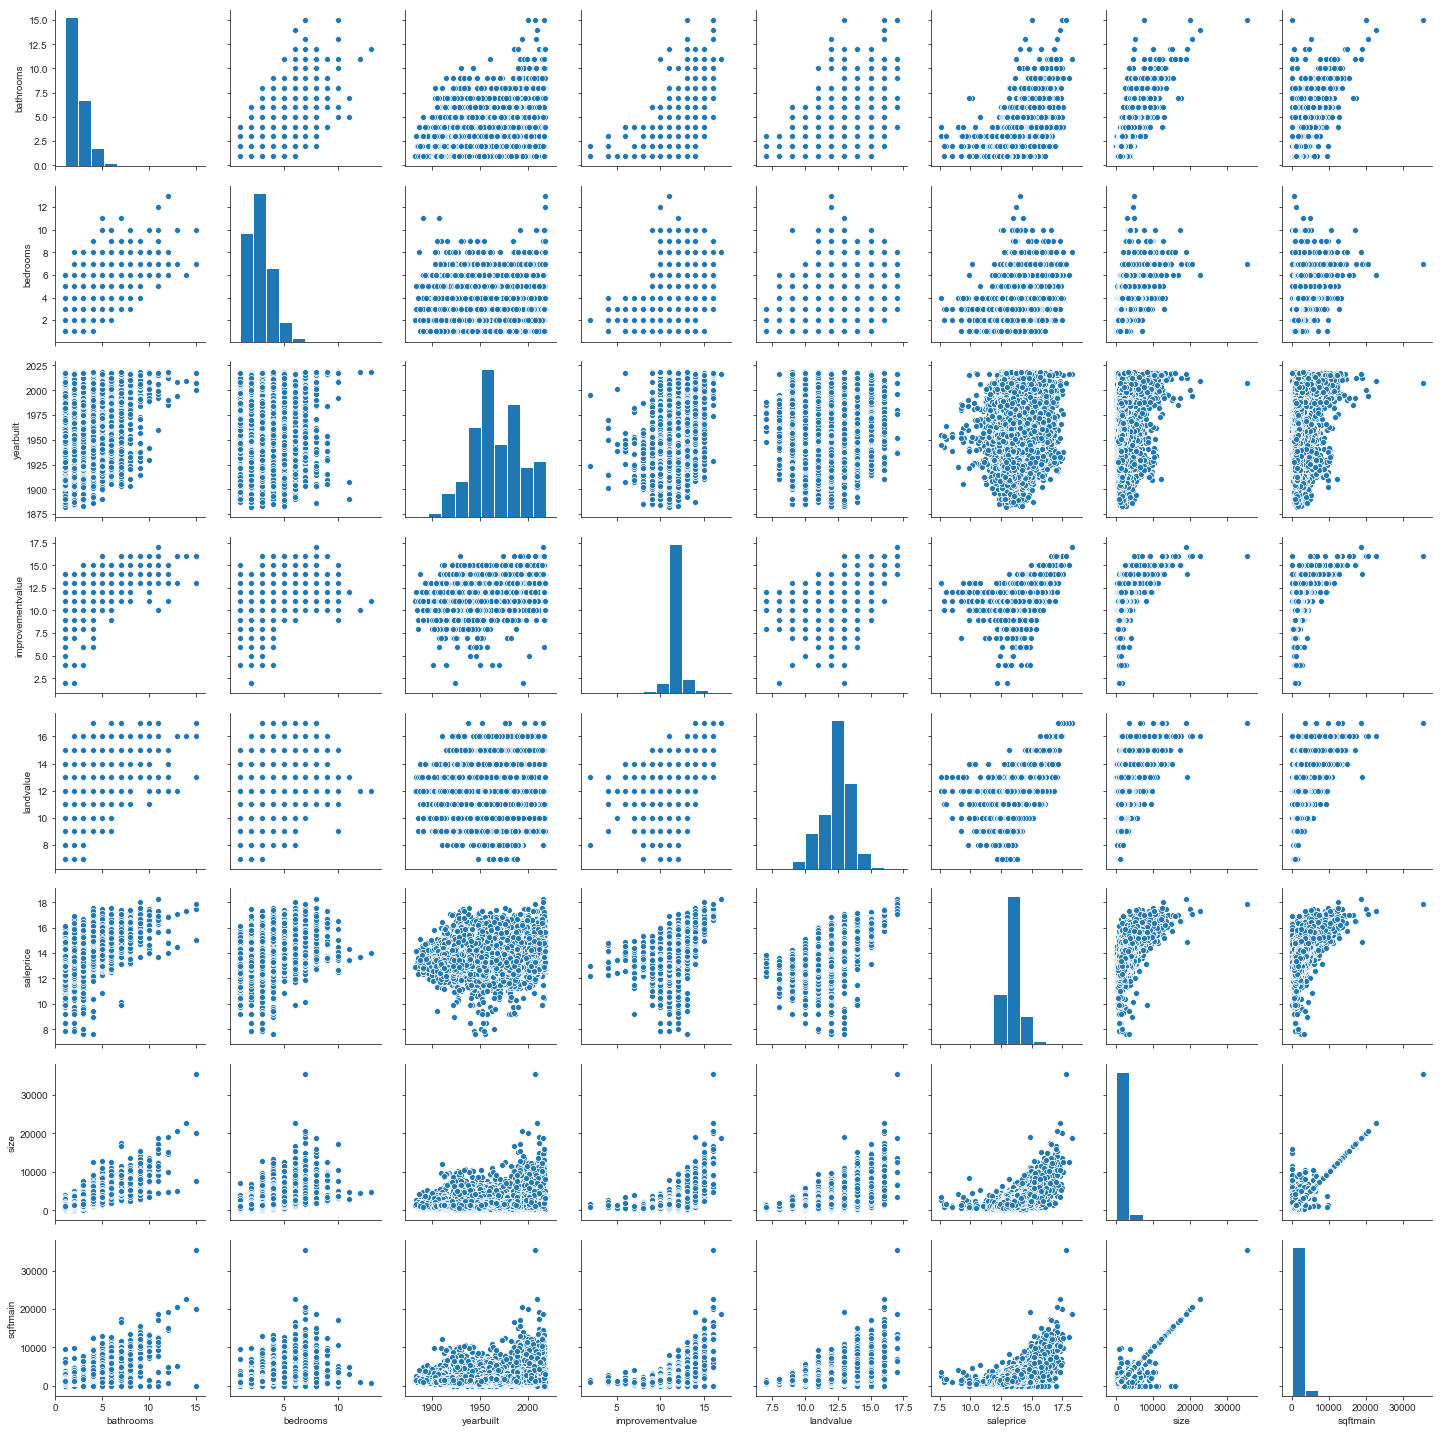

In [7]:
f = sfr[['bathrooms', 'bedrooms', 'yearbuilt', 'improvementvalue', 'landvalue',
         'saleprice', 'size', 'sqftmain']]

f['yearbuilt'] = f['yearbuilt'].astype(int)

f['saleprice'] = f['saleprice'].apply(lambda x:np.log(x))
f['improvementvalue'] = f['improvementvalue'].apply(lambda x:np.log(x).astype(int))
# f = f[(f['improvementvalue'] != float('inf')) and (f['improvementvalue'] != float('-inf'))]

f['landvalue'] = f['landvalue'].apply(lambda x:np.log(x).astype(int))
# f = f[(f['landvalue'] != float('inf')) and (f['landvalue'] != float('-inf'))]
f = f[(f['yearbuilt'] > 0) & (f['bedrooms'] < 20) & (f['bathrooms'] < 20) & (f['improvementvalue'] > 0)]

# f.reset_index(drop=True, inplace=True)

pp = sns.pairplot(f)

# Residential Area and Sale Price

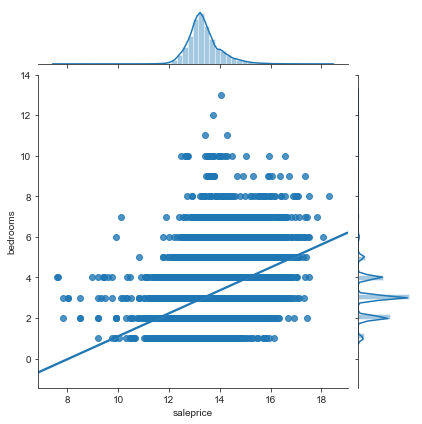

In [8]:
sns.set_style("white")
sns.set_style("ticks")

d = f[f['bedrooms'] < 20]

g = sns.JointGrid(x="saleprice", y="bedrooms", data=d)
g = g.plot(sns.regplot, sns.distplot)

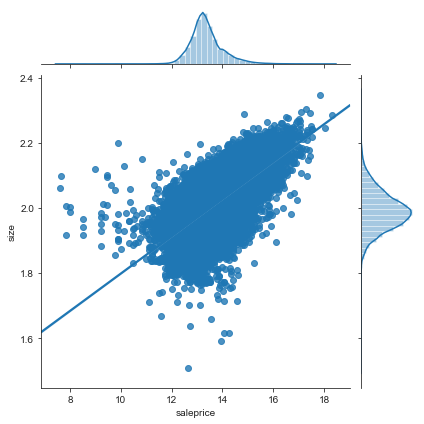

In [21]:
sns.set_style("white")
sns.set_style("ticks")

f['size'] = f['size'].apply(lambda x:np.log(x))

g = sns.JointGrid(x="saleprice", y="size", data=f)
g = g.plot(sns.regplot, sns.distplot)

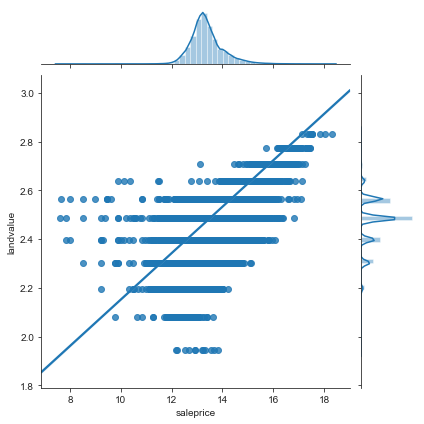

In [10]:
sns.set_style("white")
sns.set_style("ticks")

f['landvalue'] = f['landvalue'].apply(lambda x:np.log(x))

g = sns.JointGrid(x="saleprice", y="landvalue", data=f)
g = g.plot(sns.regplot, sns.distplot)

# Remove additional outliers

As we saw above, we want to pull out any additional outlier data.

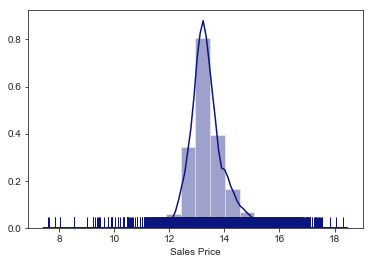

In [11]:
d = pd.Series(np.log(sfr.saleprice))

ax = sns.distplot(d, bins=20, kde=True, rug=True, color="#0A157F", axlabel='Sales Price')

# Remove extreme outliers

Remove the most extreme outliers from the data using this function:

In [12]:
first_quartile = sfr['saleprice'].describe()['25%']
third_quartile = sfr['saleprice'].describe()['75%']

# Interquartile range
iqr = third_quartile - first_quartile

# Remove outliers
sfr_c = sfr[(sfr['saleprice'] > (first_quartile - 3 * iqr)) &
            (sfr['saleprice'] < (third_quartile + 3 * iqr))]

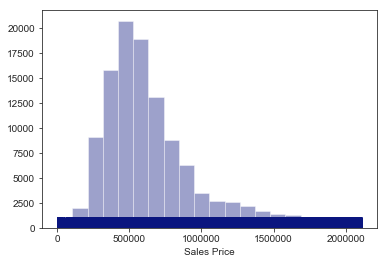

In [13]:
d = pd.Series(np.log(sfr_c.saleprice))
d = sfr_c.saleprice

ax = sns.distplot(d, bins=20, kde=False, rug=True, color="#0A157F", axlabel='Sales Price')

In [14]:
sfr_c.sort_values(by=['saleprice'], ascending=False).head(10)

,ain,bathrooms,bedrooms,effectiveyearbuilt,formatted_saledate,formatted_saleprice,formatted_size,generalusetype,impbaseyear,improvementvalue,landbaseyear,landvalue,mult_geom,plot_id,propertylocation,propertytype,propertyusecode,recordingdate,rollyear,saaddr,saaddr2,safract,saledate,saleprice,saleyear,sanum,sastr,saunit,size,specificusedetail1,specificusedetail2,specificusetype,sqftmain,taxratearea,taxratearea_city,the_geom,totbuildingdatalines,units,yearbuilt,zipcode_p
cartodb_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
57121,4366004005,3,3,1969,03/31/2017,"$2,109,021","2,886",Residential,2017,430236,2017,1720944,1,63186,234 N GLENROY AVE LOS ANGELES CA 90049,SFR,0101,20170331,2018,234 N GLENROY AVE,LOS ANGELES CA 90049,,2017,2109021,2017,234,GLENROY AVE,,2886,,Pool,Single Family Residence,2886,67,LOS ANGELES,0106000020E61000000100000001030000000100000008...,1,1,1955,90049-2418
76378,4443017010,3,4,1972,12/20/2017,"$2,109,021","2,256",Residential,2018,421800,2018,1687200,1,64563,3429 CLOUDCROFT DR MALIBU CA 90265,SFR,0100,20171220,2018,3429 CLOUDCROFT DR,MALIBU CA 90265,,2017,2109021,2017,3429,CLOUDCROFT DR,,2256,,,Single Family Residence,2256,8645,unincorporated,0106000020E61000000100000001030000000100000006...,1,1,1965,90265-5631
77528,5702021007,3,5,1929,09/06/2018,"$2,108,021","3,638",Residential,1975,125820,1975,44143,1,88565,7 RICHLAND PL PASADENA CA 91103,SFR,0100,19901109,2018,7 RICHLAND PL,PASADENA CA 91103,,2018,2108021,2018,7,RICHLAND PL,,3638,,,Single Family Residence,3638,7500,PASADENA,0106000020E61000000100000001030000000100000008...,1,1,1929,91103-2837
77518,5333008025,5,4,1951,09/11/2018,"$2,108,021","2,698",Residential,2016,472812,2016,1521480,1,76383,2580 LORAIN RD SAN MARINO CA 91108,SFR,0100,20150818,2018,2580 LORAIN RD,SAN MARINO CA 91108,,2018,2108021,2018,2580,LORAIN RD,,2698,,,Single Family Residence,2698,8541,SAN MARINO,0106000020E6100000010000000103000000010000000A...,1,1,1937,91108-2907
116951,5587007017,4,4,1949,06/29/2018,"$2,107,521","3,765",Residential,1975,257284,1975,62890,1,85291,5688 HOLLY OAK DR LOS ANGELES CA 90068,SFR,0101,19970523,2018,5688 HOLLY OAK DR,LOS ANGELES CA 90068,,2018,2107521,2018,5688,HOLLY OAK DR,,3765,,Pool,Single Family Residence,3765,13,LOS ANGELES,0106000020E61000000100000001030000000100000008...,1,1,1941,90068-2522
59303,4174010023,2,3,1957,07/31/2018,"$2,107,021","1,630",Residential,1975,37459,1975,64189,1,53732,617 31ST ST MANHATTAN BEACH CA 90266,SFR,0100,19930707,2018,617 31ST ST,MANHATTAN BEACH CA 90266,,2018,2107021,2018,617,31ST ST,,1630,,,Single Family Residence,1630,6174,MANHATTAN BEACH,0106000020E61000000100000001030000000100000005...,1,1,1951,90266-3419
76185,5713036020,4,6,1980,12/15/2017,"$2,106,021","3,313",Residential,2018,954800,2018,1151100,1,88862,295 PALMETTO DR PASADENA CA 91105,SFR,0101,20171215,2018,295 PALMETTO DR,PASADENA CA 91105,,2017,2106021,2017,295,PALMETTO DR,,3313,,Pool,Single Family Residence,3313,7500,PASADENA,0106000020E61000000100000001030000000100000009...,1,1,1919,91105-1813
69876,4262011004,1,2,1923,11/05/2018,"$2,105,521","1,052",Residential,1975,5360,1975,99739,1,57809,1617 BARRY AVE LOS ANGELES CA 90025,SFR,0100,19771020,2018,1617 BARRY AVE,LOS ANGELES CA 90025,,2018,2105521,2018,1617,BARRY AVE,,1052,,,Single Family Residence,1052,67,LOS ANGELES,0106000020E61000000100000001030000000100000006...,1,1,1922,90025-4001
116086,5577021007,3,4,1957,09/21/2018,"$2,105,021","2,319",Residential,1975,105129,1975,53844,1,84987,2950 LAKERIDGE DR LOS ANGELES CA 90068,SFR,0101,19840723,2018,2950 LAKERIDGE DR,LOS ANGELES CA 90068,,2018,2105021,2018,2950,LAKERIDGE DR,,2319,,Pool,Single Family Residence,2319,13,LOS ANGELES,0106000020E61000000100000001030000000100000005...,1,1,1957,90068-1808


# Spatial Data Exploration and Variables

Before we run our prediction model, let's look at the spatial relationships between the different buildings across the city. 

We will use [**PySAL**](https://pysal.org/index.html) or Python Spatial Analysis Library to perform the spatial data exploration. We will identify significant clusters of high home sales using the [`esda`](https://esda.readthedocs.io/en/latest/) module from PySAL.

In [15]:
cc.write(sfr_c, 'la_eval_clean', overwrite=True)

Table successfully written to CARTO: https://mforrest-isolines.carto.com/dataset/la_eval_clean


In [16]:
sfr_pysal = cc.read('la_eval_clean', decode_geom=True)
sfr_ps = sfr_pysal.sort_values(ascending=False, by='formatted_saledate')
sfr_ps.head(2)

,ain,bathrooms,bedrooms,effectiveyearbuilt,formatted_saledate,formatted_saleprice,formatted_size,generalusetype,impbaseyear,improvementvalue,landbaseyear,landvalue,mult_geom,plot_id,propertylocation,propertytype,propertyusecode,recordingdate,rollyear,saaddr,saaddr2,safract,saledate,saleprice,saleyear,sanum,sastr,saunit,size,specificusedetail1,specificusedetail2,specificusetype,sqftmain,taxratearea,taxratearea_city,the_geom,totbuildingdatalines,units,yearbuilt,zipcode_p,geometry
cartodb_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
136952,8207003065,2,2,1972,12/31/2018,"$350,003",954,Residential,2016,150858,2016,176868,1,126513,"1448 COUNTRYWOOD AVE, NO 32 HACIENDA HEIGHTS ...",CND,010C,20160629,2018,"1448 COUNTRYWOOD AVE, NO 32",HACIENDA HEIGHTS CA 91745,,2018,350003,2018,1448,COUNTRYWOOD AVE,NO 32,954,,Condominium,Single Family Residence,954,4475,unincorporated,0106000020E6100000010000000103000000010000005E...,1,1,1972,91745-3056,(POLYGON ((-117.9437483788245 34.0002708489307...
98572,6361006017,3,4,1968,12/31/2018,"$690,006","2,126",Residential,2005,249900,2005,456100,1,103618,9305 DOWNEY AVE DOWNEY CA 90240,SFR,0100,20060510,2018,9305 DOWNEY AVE,DOWNEY CA 90240,,2018,690006,2018,9305,DOWNEY AVE,,2126,,,Single Family Residence,2126,3291,DOWNEY,0106000020E61000000100000001030000000100000007...,1,1,1951,90240-2825,(POLYGON ((-118.1198810527051 33.9590943995692...


In [17]:
sfr_ps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113361 entries, 136952 to 137552
Data columns (total 41 columns):
ain                     113361 non-null object
bathrooms               113361 non-null int64
bedrooms                113361 non-null int64
effectiveyearbuilt      113361 non-null int64
formatted_saledate      113361 non-null object
formatted_saleprice     113361 non-null object
formatted_size          113361 non-null object
generalusetype          113361 non-null object
impbaseyear             113361 non-null int64
improvementvalue        113361 non-null int64
landbaseyear            113361 non-null int64
landvalue               113361 non-null int64
mult_geom               113361 non-null int64
plot_id                 113361 non-null int64
propertylocation        113361 non-null object
propertytype            113361 non-null object
propertyusecode         113361 non-null object
recordingdate           113361 non-null int64
rollyear                113361 non-null int64
sa

# Drop duplicate geometries

We need to drop duplicate geometries from the dataset for the Moran's I evaluation since that will cause an error with PySAL.

In [18]:
sfr_ps.drop_duplicates(subset = "plot_id", inplace = True) 
sfr_ps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92291 entries, 136952 to 137552
Data columns (total 41 columns):
ain                     92291 non-null object
bathrooms               92291 non-null int64
bedrooms                92291 non-null int64
effectiveyearbuilt      92291 non-null int64
formatted_saledate      92291 non-null object
formatted_saleprice     92291 non-null object
formatted_size          92291 non-null object
generalusetype          92291 non-null object
impbaseyear             92291 non-null int64
improvementvalue        92291 non-null int64
landbaseyear            92291 non-null int64
landvalue               92291 non-null int64
mult_geom               92291 non-null int64
plot_id                 92291 non-null int64
propertylocation        92291 non-null object
propertytype            92291 non-null object
propertyusecode         92291 non-null object
recordingdate           92291 non-null int64
rollyear                92291 non-null int64
saaddr                

# Create spatial weights

First we need to evaluate the spatial relationships between all the different buildings. Since these geometries do not touch, we want to use the KNN weights from PySAL:

https://libpysal.readthedocs.io/en/latest/generated/libpysal.weights.KNN.html#libpysal.weights.KNN

In [19]:
W = libpysal.weights.KNN.from_dataframe(sfr_ps, k=10)
W.transform = 'r'

/Users/jsanchez/Documents/GitHub/end-to-end-demo/venv/lib/python3.7/site-packages/libpysal/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 19 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)


# Moran's I Local

To identify the significant clusters, we will use the Moran's I Local analysis from PySAL to identify clusters of high sale prices. Spatial autocorrelation as described by the PySAL examples is:

*The concept of spatial autocorrelation relates to the combination of two types of similarity: spatial similarity and attribute similarity. Although there are many different measures of spatial autocorrelation, they all combine these two types of similarity into a summary measure.*

http://darribas.org/gds_scipy16/ipynb_md/04_esda.html
https://nbviewer.jupyter.org/github/pysal/esda/blob/master/notebooks/Spatial%20Autocorrelation%20for%20Areal%20Unit%20Data.ipynb

In [20]:
import esda
moran = esda.Moran_Local(sfr_ps.saleprice, W, transformation = "r")

ModuleNotFoundError: No module named 'esda'

# Moran's Quads

We will use these values to create human readable clusters from the analysis - from the PySAL docs:

**q : array**

(if permutations>0) values indicate quandrant location 1 HH, 2 LH, 3 LL, 4 HL

In [ ]:
moran.q[10:100]

# Similarity

From PySAL Docs:

**p_sim : array**

(if permutations>0) p-values based on permutations (one-sided) null: spatial randomness alternative: the observed Ii is further away or extreme from the median of simulated values. It is either extremely high or extremely low in the distribution of simulated Is.

In [ ]:
moran.p_sim

From PySAL Docs:

**p_z_sim : array**

(if permutations>0) p-values based on standard normal approximation from permutations (one-sided) for two-sided tests, these values should be multiplied by 2

In [ ]:
moran.p_z_sim

In [ ]:
lag = libpysal.weights.lag_spatial(W, sfr_ps.saleprice)
data = sfr_ps.saleprice

In [ ]:
sig = 1 * (moran.p_sim < 0.05)
HH = 1 * (sig * moran.q==1)
LL = 3 * (sig * moran.q==3)
LH = 2 * (sig * moran.q==2)
HL = 4 * (sig * moran.q==4)
spots = HH + LL + LH + HL
spots

In [ ]:
spot_labels = [ '0 Non-Significant', 'HH - Hot Spot', 'LH - Donut', 'LL - Cold Spot', 'HL - Diamond']
labels = [spot_labels[i] for i in spots]

In [ ]:
moran_to_carto = sfr_ps.assign(cl=labels, p_sim = moran.p_sim, p_z_sim = moran.p_z_sim)
moran_to_carto.head(2)

In [ ]:
cc.write(moran_to_carto, 'manhattan_moran', overwrite=True)

In [6]:

buckets='buckets($cl,["HH - Hot Spot","HL - Diamond","LH - Donut","LL - Cold Spot"])';
colorRamp='ramp('+buckets+',[#cf597e, #e88471, #39b185, #009392])';
strokeRamp='ramp('+buckets+',[#B54E6F, #CF7765, #309671, #007A7A],#636363)';
opacityStart='opacity('+colorRamp+',1)';
opacityEnd='opacity('+colorRamp+',0.6)';

vector.vmap(
    [vector.Layer(
        'manhattan_moran',
        color='ramp(zoomrange([0,16]),['+opacityStart+','+opacityEnd+'])',
        strokeWidth='ramp(zoomrange([12,14]),[0,0.7])',
        strokeColor=strokeRamp,
        interactivity={
            'cols': ['cl','formatted_saleprice','formatted_size','generalusetype'],
            'event': 'hover'
        }
    ),],
    context=cc,
    basemap=vector.BaseMaps.voyager
)

# HH - Hot Spots

We can see that there are clusters of high sale price properties in the Upper East Side and the West Village

In [3]:
qHH = '''
      SELECT * FROM manhattan_moran
      WHERE cl = 'HH - Hot Spot'
      '''

vector.vmap(
    [vector.QueryLayer(
        qHH,
        color='ramp(zoomrange([0,16]),[opacity(#cf597e,1),opacity(#cf597e,0.6)])',
        strokeWidth='ramp(zoomrange([12,14]),[0,0.7])',
        strokeColor='#B54E6F',
        interactivity={
            'cols': ['formatted_saleprice','formatted_size','generalusetype'],
            'header': ['<h2>HH - Hot Spot<h2>', ],
            'event': 'hover'
        }
    ),
    ],
    context=cc,
    basemap=vector.BaseMaps.voyager
)

# LL - Cold Spots

Upper Manhattan contains large clusters of low sale price properties

In [5]:
qLL = '''
      SELECT * FROM manhattan_moran
      WHERE cl = 'LL - Cold Spot'
      '''

vector.vmap(
    [vector.QueryLayer(
        qLL,
        color='ramp(zoomrange([0,16]),[opacity(#009392,1),opacity(#009392,0.6)])',
        strokeWidth='ramp(zoomrange([12,14]),[0,0.7])',
        strokeColor='#007A7A',
        interactivity={
            'cols': ['formatted_saleprice','formatted_size','generalusetype'],
            'header': ['<h2>LL - Cold Spot<h2>', ],
            'event': 'hover'
        }
    ),],
    context=cc,
    basemap=vector.BaseMaps.voyager
)

# HL - Diamond

Properties of high sale price near low sale price properties are also concentrated in LA

In [4]:
qHL = '''
      SELECT * FROM manhattan_moran
      WHERE cl = 'HL - Diamond'
      '''

vector.vmap(
    [vector.QueryLayer(
        qHL,
        color='ramp(zoomrange([0,16]),[opacity(#e88471,1),opacity(#e88471,0.6)])',
        strokeWidth='ramp(zoomrange([12,14]),[0,0.7])',
        strokeColor='#CF7765',
        interactivity={
            'cols': ['formatted_saleprice','formatted_size','generalusetype'],
            'header': ['<h2>HL - Diamond<h2>', ],
            'event': 'hover'
        }
    ),],
    context=cc,
    basemap=vector.BaseMaps.voyager
)

# LH - Donut

Low sale price properties near high sale price properties are scattered across the city

In [7]:
qLH = '''
      SELECT * FROM manhattan_moran
      WHERE cl = 'LH - Donut'
      '''

colorRamp='ramp('+buckets+',[#cf597e, #e88471, #39b185, #009392])';
strokeRamp='ramp('+buckets+',[#B54E6F, #CF7765, #309671, #007A7A],#636363)';


vector.vmap(
    [vector.QueryLayer(
        qLH,
        color='ramp(zoomrange([0,16]),[opacity(#39b185,1),opacity(#39b185,0.6)])',
        strokeWidth='ramp(zoomrange([12,14]),[0,0.7])',
        strokeColor='#309671',
        interactivity={
            'cols': ['formatted_saleprice','formatted_size','generalusetype'],
            'header': ['<h2>LH - Donut<h2>', ],
            'event': 'hover'
        }
    ),],
    context=cc,
    basemap=vector.BaseMaps.voyager
)